In [62]:
import os
import h5py
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [63]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, \
    AspectAwarePreprocessor, MeanSubtractionPreProcessor, SimplePreProcessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.io import HDF5DatasetGenerator
from loader_util.nn.conv import FCHeadNet, LeNet, AlexNet
from loader_util.callbacks import TrainingMonitor, EpochCheckpoint
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler

In [64]:
# construct the train image generator
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode='nearest')

In [65]:
batch_size = 64
epoch_num = 300

# initialise the image preprocessors
sp = SimplePreProcessor(width=28, height=28)
iap = ImageToArrayPreprocessor()

In [66]:
# initialise the data paths

dbBase = r"/home/mhasan3/Desktop/WorkFolder/DataRepo"
dbTrainPath = f"{dbBase}//train_threshinv_5class_28px1px_255div.hdf5"
dbValidPath = f"{dbBase}//validate_threshinv_5class_28px1px_255div.hdf5"

# get the no. of classes
trainFile = h5py.File(name=dbTrainPath, mode="r")
class_num = len(list(np.unique(trainFile["labels"])))
print(f"Total no. of classes in dataset: {class_num}")

# get unique labels
label_names = list(trainFile["label_names"])
label_names = [label.decode() for label in label_names]
print(f"Unique Labels: {labels}")

Total no. of classes in dataset: 5
Unique Labels: [4 4 0 ... 1 1 1]


In [67]:
##### consider class weight discrepency
le = LabelEncoder()
labels = le.fit_transform(trainFile["labels"])
encoded_labels = to_categorical(labels)

classLabels = le.classes_
classTotals = encoded_labels.sum(axis=0) # type: np.ndarray
classWeight = classTotals.max() / classTotals

print(f"ClassLabels: {classLabels}")
print(f"ClassWeights: {classWeight}")

ClassLabels: [0 1 2 3 4]
ClassWeights: [1.0031143 1.6970495 1.4366637 1.        1.5200566]


In [68]:
# initialise the train and valid generators
trainGen = HDF5DatasetGenerator(dbPath=dbTrainPath,
                                batchSize=batch_size,
                                preprocessors=[sp, iap],
                                classes=class_num,
                                aug=aug)

valGen = HDF5DatasetGenerator(dbPath=dbValidPath,
                              batchSize=batch_size,
                              preprocessors=[sp, iap],
                              classes=class_num)

In [69]:
# define the Learning Rate Scheduler

initial_rate = 5e-3

def poly_decay(epoch):
    max_epochs = epoch_num
    baseLR = initial_rate
    power = 1.0
    
    alpha = baseLR * (1 - (epoch / float(max_epochs))) ** power
    return alpha

In [70]:
#model = AlexNet.build(width=80, height=80, depth=3, classes=class_num)
model = LeNet.build(width=28,
                    height=28,
                    depth=1,
                    classes=5)

In [71]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
activation_12 (Activation)   (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_13 (Activation)   (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2450)              0         
__________

In [72]:
# compile and optimise model
opt = SGD(lr=initial_rate)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# construct callbacks
path = os.path.sep.join([dbBase, f'{os.getpid()}.png'])
callbacks = [TrainingMonitor(path),
             LearningRateScheduler(poly_decay),]
             #EpochCheckpoint(outputPath=dbBase)]

In [73]:
# train the head for few epochs
H = model.fit_generator(
    trainGen.generator(),
    steps_per_epoch=trainGen.numImages//batch_size,
    validation_data=valGen.generator(),
    validation_steps=valGen.numImages//batch_size,
    epochs=epoch_num,
    max_queue_size=10,
    verbose=1,
    callbacks=callbacks,
    class_weight=classWeight
)

Epoch 1/300
198/198 [==============================] - 3s 17ms/step - loss: 1.3826 - acc: 0.3787 - val_loss: 1.0830 - val_acc: 0.5566
Epoch 2/300
198/198 [==============================] - 3s 17ms/step - loss: 1.0512 - acc: 0.5988 - val_loss: 0.7976 - val_acc: 0.7338
Epoch 3/300
198/198 [==============================] - 3s 16ms/step - loss: 0.8957 - acc: 0.6683 - val_loss: 0.5740 - val_acc: 0.8261
Epoch 4/300
198/198 [==============================] - 3s 17ms/step - loss: 0.8009 - acc: 0.6991 - val_loss: 0.5232 - val_acc: 0.8241
Epoch 5/300
198/198 [==============================] - 3s 16ms/step - loss: 0.7357 - acc: 0.7204 - val_loss: 0.5094 - val_acc: 0.8349
Epoch 6/300
198/198 [==============================] - 3s 16ms/step - loss: 0.6921 - acc: 0.7384 - val_loss: 0.4634 - val_acc: 0.8500
Epoch 7/300
198/198 [==============================] - 3s 17ms/step - loss: 0.6708 - acc: 0.7473 - val_loss: 0.4272 - val_acc: 0.8665
Epoch 8/300
198/198 [==============================] - 3s 17ms

Epoch 39/300
198/198 [==============================] - 3s 17ms/step - loss: 0.4008 - acc: 0.8475 - val_loss: 0.2605 - val_acc: 0.8965
Epoch 40/300
198/198 [==============================] - 3s 17ms/step - loss: 0.4014 - acc: 0.8456 - val_loss: 0.2593 - val_acc: 0.9055
Epoch 41/300
198/198 [==============================] - 3s 17ms/step - loss: 0.3972 - acc: 0.8543 - val_loss: 0.2453 - val_acc: 0.9193
Epoch 42/300
198/198 [==============================] - 3s 16ms/step - loss: 0.4017 - acc: 0.8481 - val_loss: 0.2491 - val_acc: 0.9138
Epoch 43/300
198/198 [==============================] - 3s 17ms/step - loss: 0.3858 - acc: 0.8578 - val_loss: 0.2388 - val_acc: 0.9092
Epoch 44/300
198/198 [==============================] - 3s 16ms/step - loss: 0.3835 - acc: 0.8582 - val_loss: 0.2402 - val_acc: 0.9101
Epoch 45/300
198/198 [==============================] - 3s 16ms/step - loss: 0.3816 - acc: 0.8585 - val_loss: 0.2517 - val_acc: 0.9086
Epoch 46/300
198/198 [==============================] -

Epoch 77/300
198/198 [==============================] - 3s 16ms/step - loss: 0.2976 - acc: 0.8876 - val_loss: 0.1719 - val_acc: 0.9373
Epoch 78/300
198/198 [==============================] - 4s 18ms/step - loss: 0.3019 - acc: 0.8868 - val_loss: 0.1586 - val_acc: 0.9375
Epoch 79/300
198/198 [==============================] - 3s 17ms/step - loss: 0.2908 - acc: 0.8951 - val_loss: 0.1808 - val_acc: 0.9331
Epoch 80/300
198/198 [==============================] - 3s 16ms/step - loss: 0.2983 - acc: 0.8912 - val_loss: 0.1780 - val_acc: 0.9401
Epoch 81/300
198/198 [==============================] - 3s 17ms/step - loss: 0.2958 - acc: 0.8887 - val_loss: 0.1625 - val_acc: 0.9406
Epoch 82/300
198/198 [==============================] - 3s 17ms/step - loss: 0.2879 - acc: 0.8902 - val_loss: 0.1456 - val_acc: 0.9428
Epoch 83/300
198/198 [==============================] - 4s 19ms/step - loss: 0.2935 - acc: 0.8905 - val_loss: 0.1571 - val_acc: 0.9390
Epoch 84/300
198/198 [==============================] -

Epoch 115/300
198/198 [==============================] - 3s 16ms/step - loss: 0.2413 - acc: 0.9126 - val_loss: 0.1258 - val_acc: 0.9557
Epoch 116/300
198/198 [==============================] - 3s 17ms/step - loss: 0.2444 - acc: 0.9105 - val_loss: 0.1234 - val_acc: 0.9559
Epoch 117/300
198/198 [==============================] - 3s 17ms/step - loss: 0.2404 - acc: 0.9126 - val_loss: 0.1309 - val_acc: 0.9493
Epoch 118/300
198/198 [==============================] - 3s 17ms/step - loss: 0.2387 - acc: 0.9119 - val_loss: 0.1383 - val_acc: 0.9421
Epoch 119/300
198/198 [==============================] - 3s 17ms/step - loss: 0.2357 - acc: 0.9123 - val_loss: 0.1491 - val_acc: 0.9412
Epoch 120/300
198/198 [==============================] - 3s 17ms/step - loss: 0.2350 - acc: 0.9149 - val_loss: 0.1289 - val_acc: 0.9498
Epoch 121/300
198/198 [==============================] - 3s 17ms/step - loss: 0.2392 - acc: 0.9111 - val_loss: 0.1279 - val_acc: 0.9526
Epoch 122/300
198/198 [=========================

Epoch 153/300
198/198 [==============================] - 3s 17ms/step - loss: 0.2011 - acc: 0.9270 - val_loss: 0.1036 - val_acc: 0.9586
Epoch 154/300
198/198 [==============================] - 3s 17ms/step - loss: 0.2064 - acc: 0.9234 - val_loss: 0.0949 - val_acc: 0.9688
Epoch 155/300
198/198 [==============================] - 3s 16ms/step - loss: 0.2049 - acc: 0.9260 - val_loss: 0.0994 - val_acc: 0.9603
Epoch 156/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1979 - acc: 0.9252 - val_loss: 0.1091 - val_acc: 0.9638
Epoch 157/300
198/198 [==============================] - 3s 17ms/step - loss: 0.2108 - acc: 0.9227 - val_loss: 0.0914 - val_acc: 0.9642
Epoch 158/300
198/198 [==============================] - 3s 16ms/step - loss: 0.2011 - acc: 0.9244 - val_loss: 0.1259 - val_acc: 0.9564
Epoch 159/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1996 - acc: 0.9252 - val_loss: 0.1008 - val_acc: 0.9662
Epoch 160/300
198/198 [=========================

Epoch 191/300
198/198 [==============================] - 3s 16ms/step - loss: 0.1844 - acc: 0.9335 - val_loss: 0.0898 - val_acc: 0.9575
Epoch 192/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1825 - acc: 0.9337 - val_loss: 0.0744 - val_acc: 0.9741
Epoch 193/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1799 - acc: 0.9355 - val_loss: 0.0647 - val_acc: 0.9844
Epoch 194/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1747 - acc: 0.9336 - val_loss: 0.0793 - val_acc: 0.9728
Epoch 195/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1829 - acc: 0.9338 - val_loss: 0.0992 - val_acc: 0.9625
Epoch 196/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1851 - acc: 0.9322 - val_loss: 0.0775 - val_acc: 0.9746
Epoch 197/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1797 - acc: 0.9342 - val_loss: 0.0741 - val_acc: 0.9741
Epoch 198/300
198/198 [=========================

Epoch 229/300
198/198 [==============================] - 3s 16ms/step - loss: 0.1626 - acc: 0.9425 - val_loss: 0.0725 - val_acc: 0.9711
Epoch 230/300
198/198 [==============================] - 3s 16ms/step - loss: 0.1589 - acc: 0.9427 - val_loss: 0.0784 - val_acc: 0.9697
Epoch 231/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1607 - acc: 0.9430 - val_loss: 0.0766 - val_acc: 0.9743
Epoch 232/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1628 - acc: 0.9412 - val_loss: 0.0743 - val_acc: 0.9728
Epoch 233/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1681 - acc: 0.9378 - val_loss: 0.0786 - val_acc: 0.9711
Epoch 234/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1619 - acc: 0.9421 - val_loss: 0.0806 - val_acc: 0.9702
Epoch 235/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1610 - acc: 0.9414 - val_loss: 0.0689 - val_acc: 0.9800
Epoch 236/300
198/198 [=========================

Epoch 267/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1495 - acc: 0.9475 - val_loss: 0.0609 - val_acc: 0.9787
Epoch 268/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1524 - acc: 0.9463 - val_loss: 0.0671 - val_acc: 0.9748
Epoch 269/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1468 - acc: 0.9487 - val_loss: 0.0667 - val_acc: 0.9724
Epoch 270/300
198/198 [==============================] - 4s 18ms/step - loss: 0.1501 - acc: 0.9447 - val_loss: 0.0716 - val_acc: 0.9706
Epoch 271/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1552 - acc: 0.9455 - val_loss: 0.0658 - val_acc: 0.9739
Epoch 272/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1481 - acc: 0.9470 - val_loss: 0.0619 - val_acc: 0.9796
Epoch 273/300
198/198 [==============================] - 3s 17ms/step - loss: 0.1514 - acc: 0.9454 - val_loss: 0.0647 - val_acc: 0.9776
Epoch 274/300
198/198 [=========================

In [74]:
# save the model
model.save(f"{dbBase}//model_5class_28px1px_threshinv.hdf5")

In [19]:
# do inference on a single image

new_model = load_model(f"{dbBase}//model_10class_28px1px_threshinv.hdf5")
label_to_name_dict = {
    0: 'Bearings',
    1: 'Bolts',
    2: 'Brackets',
    3: 'Bushing',
    4: 'Collets', 
    5: 'Pipes',
    6: 'PushRings',
    7: 'Springs',
    8: 'Sprockets',
    9: 'Washers'
}
# image here also needs to be threshold inveresed
image_path = r'/home/mhasan3/Desktop/WorkFolder/inference_10class/bearing.png'
test_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
aap = AspectAwarePreprocessor(28, 28)
iap = ImageToArrayPreprocessor()

preprocessors = [aap, iap]

preprocessed_image = test_image.copy()
for preprocessor in preprocessors:
    preprocessed_image = preprocessor.preprocess(preprocessed_image)
    

preprocessed_image = preprocessed_image.astype('float32')
preprocessed_image = preprocessed_image / 255.0
preprocessed_image.shape

(28, 28, 1)

In [20]:
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
print(new_model.predict(preprocessed_image))
num = new_model.predict(preprocessed_image).argmax(axis=1)[0]
print(label_to_name_dict[num])

[[1.6369487e-01 1.4096259e-20 3.4939740e-03 1.8882759e-04 3.7379526e-02
  1.2817104e-02 4.2529630e-17 1.6092326e-01 4.0705238e-02 5.8079720e-01]]
Washers


In [75]:
# calculate the classification report

from tensorflow.keras.utils import to_categorical
validDB = h5py.File(dbValidPath, mode="r")
testx = validDB["images"][:]
testy = to_categorical(validDB["labels"][:], class_num)
preds = model.predict(testx, batch_size=batch_size)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1377
           1       0.99      1.00      1.00       813
           2       1.00      0.97      0.99       961
           3       0.98      0.95      0.97      1380
           4       0.94      0.99      0.97       909

    accuracy                           0.98      5440
   macro avg       0.98      0.98      0.98      5440
weighted avg       0.98      0.98      0.98      5440



In [76]:
label_names

['Bearings', 'Bolts', 'Brackets', 'Bushing', 'Collets']

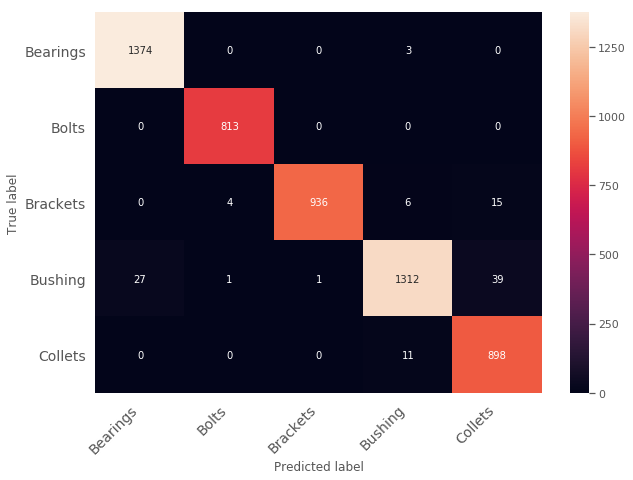

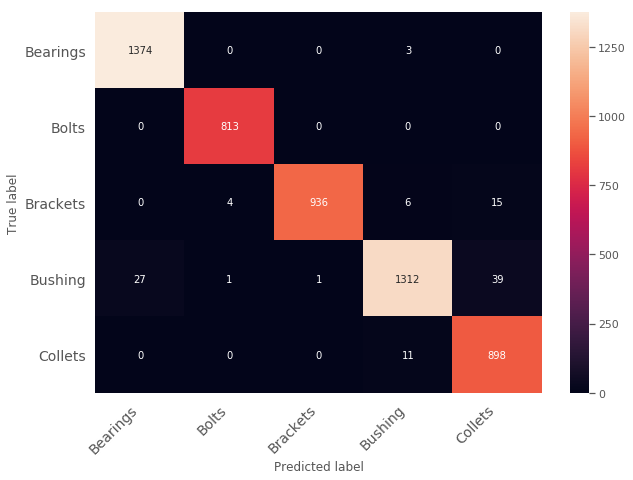

In [77]:
# print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testy.argmax(axis=1),
                 preds.argmax(axis=1))

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

print_confusion_matrix(cm, class_names=label_names)